
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h1> Business Challenge II - Spaceship Titanic</h1>
<h0> BCH-7812 | Predict which passengers are transported to an alternate dimension </h0>

<br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

Team: Group 10

Roger Lopez Benet |
Astrid Akpaca |
RYOSUKE OGATA |
Jing Li |
Magda Albino Useche


# Index

Dataset Exploration

* Importing libraries
* Setting Pandas print options
* Loading dataset
* Exploring dataset


Feature Engineering

* Developing new variables
* Trend-Based Features between the dependent variable (Transported) and independent variables 



Model Development

* Plotting predictions
* Developing candidate statmodels (chechking R-squared, p-values and correlations)
* Final Models 
    * KNeighborsClassifier
    * RandomForestClassifier
    * AGradientBoostingClassifier
    * Tunned KNeighborsClassifier
    * HistGradientBoostingClassifier

Introduction
------------


The Spaceship Titanic dataset was not easy to work with at the beginning, this is because the test and train sets didn’t have the same columns, in fact, the test was missing the independent variable, “Transported”. That said, we first had to clean the train set by dealing with missing values as well as transforming categorical variables into 1 and 0. And did the same for the test set. 

In addition, to adjust the scale of variables as well as to deal with skewness we executed logarithmic transformation and standardization for some of the variables. 

This allowed us to have the database ready, and from that point on, 9 models were applied in order to find the one that predicted “Transported” the best, which ended up being the StackingClassifier model. 


# This cell contains all feature egineered for the train set

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.formula.api as smf                # logistic regression
import sklearn.linear_model                          # linear modeling in scikit-learn
import sklearn.tree                                  # tree in scikit-learn
import sklearn.ensemble                              # ensemble   in scikit-learn
import sklearn.neighbors                             # neighbors in scikit-learn
from sklearn.model_selection import train_test_split # train-test split
from sklearn.metrics import roc_auc_score            # auc score
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.metrics import confusion_matrix         # confusion matrix


# setting pandas print options
pd.set_option('display.max_rows', 500)     
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)


# importing the training dataset
path             = "./spaceship-titanic/"
training_dataset = "train.csv"

# reading in the .csv file with pandas
titanic_train    = pd.read_csv(filepath_or_buffer = path + training_dataset)
########################################################################################################
# PassengerId
titanic_train['group'] = titanic_train['PassengerId'].str.split('_').str[0]
group_counts = titanic_train['group'].value_counts()
titanic_train['is_solo'] = titanic_train['group'].apply(lambda x: 1 if group_counts[x] == 1 else 0)
########################################################################################################
# HomePlanet
# Adding new columns to the 'titanic_test' dataframe to store binary values indicating passengers' home planet
titanic_train['HomePlanet_Europa'] = 0
titanic_train['HomePlanet_Earth'] = 0
titanic_train['HomePlanet_Mars'] = 0

for index, value in enumerate(titanic_train['HomePlanet']):
    if value == 'Europa':
        titanic_train.loc[index, 'HomePlanet_Europa'] = 1 # Set the value of 'HomePlanet_Europa' to 1 if the value of 'HomePlanet' is 'Europa'
    elif value == 'Earth':
        titanic_train.loc[index, 'HomePlanet_Earth'] = 1  # Set the value of 'HomePlanet_Earth' to 1 if the value of 'HomePlanet' is 'Earth'
    elif value == 'Mars':
        titanic_train.loc[index, 'HomePlanet_Mars'] = 1   # Set the value of 'HomePlanet_Mars' to 1 if the value of 'HomePlanet' is 'Mars'
    elif pd.isna(value) == True:
        pass
    else:
        print('Error', index, value) # Print an error message if the value of 'HomePlanet' is not one of the expected values
########################################################################################################
# CryoSleep
# Adding new columns for CryoSleep_True and CryoSleep_False
titanic_train['CryoSleep_True'] = 0
titanic_train['CryoSleep_False'] = 0

# Looping through the values of 'CryoSleep' and assigning 1 to the respective column based on the condition
for index, value in enumerate(titanic_train['CryoSleep']):
    if value == True:
        titanic_train.loc[index, 'CryoSleep_True'] = 1   # if the 'CryoSleep' feature is True, encode 1 in 'CryoSleep_True' column of the same row
    elif value == False:
        titanic_train.loc[index, 'CryoSleep_False'] = 1  # if the 'CryoSleep' feature is False, encode 1 in 'CryoSleep_False' column of the same row
    elif pd.isna(value) == True:
        pass
    else:
        print('Error', index, value) # print an error message if the value is not True, False or NaN
########################################################################################################
# Cabin P/S
# Create new columns for each cabin type with default value of 0
titanic_train['Cabin_P'] = 0
titanic_train['Cabin_S'] = 0

for index, value in enumerate(titanic_train['Cabin']):
    if str(value)[-1] == 'P':
        titanic_train.loc[index, 'Cabin_P'] = 1   # if the last character in the cabin value is 'S', set 'Cabin_S' column to 1
    elif str(value)[-1] == 'S':
        titanic_train.loc[index, 'Cabin_S'] = 1
    elif pd.isna(value) == True:
        pass
    else:                                         # if none of the above, print an error message with the index and value
        print('Error', index, value)
########################################################################################################
# Destination
# Convert destination column to dummies variables
destinarion_dummies = pd.get_dummies(titanic_train['Destination'], prefix='Destination')
# Concatenate the dummies variables to the test dataframe
titanic_train = pd.concat([titanic_train, destinarion_dummies], axis=1)

# Renaming destination variables
titanic_train['Destination_55_Cancri_e'] = titanic_train['Destination_55 Cancri e']
titanic_train['Destination_PSO_J318_5_22'] = titanic_train['Destination_PSO J318.5-22']
titanic_train['Destination_TRAPPIST_1e'] = titanic_train['Destination_TRAPPIST-1e']
########################################################################################################
# Amenities
missing_col = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i in missing_col:
    titanic_train.loc[titanic_train.loc[:,i].isnull(),i]=titanic_train.loc[:,i].median()

# Total_expenses
titanic_train['Total_expenses'] = titanic_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# amenities_use
titanic_train['amenities_use'] = 0
for index, row in titanic_train.iterrows():
    
    # If any of the amenities have a value greater than 1, set amenities_use to 1
    if titanic_train.loc[index, 'RoomService'] > 1\
            or titanic_train.loc[index, 'FoodCourt'] > 1\
            or titanic_train.loc[index, 'ShoppingMall'] > 1\
            or titanic_train.loc[index, 'Spa'] > 1\
            or titanic_train.loc[index, 'Spa'] > 1:
        titanic_train.loc[index, 'amenities_use'] = 1  # Seting 'amenities_use' column to 1 for the row where at least one of the amenities is used more than once.

# Logged Amenities
titanic_train['LOG_RoomServiceF'] = np.log(titanic_train['RoomService'] +1)       # Log transforming feature
titanic_train['LOG_FoodCourtF'] = np.log(titanic_train['FoodCourt'] +1)           # Log transforming feature
titanic_train['LOG_ShoppingMallF'] = np.log(titanic_train['ShoppingMall'] +1)     # Log transforming feature
titanic_train['LOG_SpaF'] = np.log(titanic_train['Spa'] +1)                       # Log transforming feature
titanic_train['LOG_VRDeckF'] = np.log(titanic_train['VRDeck'] +1)                 # Log transforming feature
titanic_train['LOG_Total_expenses'] = np.log(titanic_train['Total_expenses'] +1)  # Log transforming feature

# LOG_RoomServiceF outliers
titanic_train['out_LOG_RoomServiceF_lo'] = 0
for index, value in enumerate(titanic_train['LOG_RoomServiceF']):
    if value < 2:
        titanic_train.loc[index, 'out_LOG_RoomServiceF_lo'] = 1
        
# LOG_FoodCourtF outliers
titanic_train['out_LOG_FoodCourtF_lo'] = 0
for index, value in enumerate(titanic_train['LOG_FoodCourtF']):
    if value < 2:
        titanic_train.loc[index, 'out_LOG_FoodCourtF_lo'] = 1
        
# LOG_ShoppingMallF outliers
titanic_train['out_LOG_ShoppingMallF_lo'] = 0
for index, value in enumerate(titanic_train['LOG_ShoppingMallF']):
    if value < 2:
        titanic_train.loc[index, 'out_LOG_ShoppingMallF_lo'] = 1
        
# LOG_SpaF outliers
titanic_train['out_LOG_SpaF_lo'] = 0
for index, value in enumerate(titanic_train['LOG_SpaF']):
    if value < 2:
        titanic_train.loc[index, 'out_LOG_SpaF_lo'] = 1
        
# LOG_VRDeckF outliers
titanic_train['out_LOG_VRDeckF_lo'] = 0
for index, value in enumerate(titanic_train['LOG_VRDeckF']):
    if value < 2:
        titanic_train.loc[index, 'out_LOG_VRDeckF_lo'] = 1
        
# LOG_Total_expenses outliers
titanic_train['out_LOG_Total_expenses_lo'] = 0
for index, value in enumerate(titanic_train['LOG_Total_expenses']):
    if value < 2:
        titanic_train.loc[index, 'out_LOG_Total_expenses_lo'] = 1
########################################################################################################
# Age
missing_col = ['Age']
for i in missing_col:
    titanic_train.loc[titanic_train.loc[:,i].isnull(),i]=titanic_train.loc[:,i].mean()

# logged Age
titanic_train['Age'] = titanic_train['Age'].replace(0, 0.01)
titanic_train['LOG_Age'] = np.log(titanic_train['Age'])

# logged age outliers
titanic_train['out_LOG_Age_lo'] = 0
for index, value in enumerate(titanic_train['LOG_Age']):
    if value < 2:
        titanic_train.loc[index, 'out_LOG_Age_lo'] = 1

# Age>18
titanic_train['Age<18'] = np.where(titanic_train['Age'] < 18, 1, 0)

# Age>18
titanic_train['Age>18'] = np.where(titanic_train['Age'] > 18, 1, 0)

# Age>45
titanic_train['Age>45'] = np.where(titanic_train['Age'] > 45, 1, 0)

titanic_train['Age>35<64'] = np.where((titanic_train['Age'] > 35) & (titanic_train['Age'] < 64), 1, 0)


# # Age>34<65 
# titanic_train['Age34AND65'] = np.where(titanic_train['Age'] > 44 titanic_train['Age34AND65'] = np.where((titanic_train['Age'] > 34) & (titanic_train['Age'] < 65), 1, 0)
# <65, 1, 0)

# TotalExp_18plus (the average total expenses per person above the age of 18 in the ship)
titanic_train['TotalExp_18plus'] = titanic_train['Total_expenses'] / titanic_train['Age>18'].sum()

titanic_train['TotalExp_18minus'] = titanic_train['Total_expenses'] / titanic_train['Age<18'].sum()

titanic_train['TotalExp_45plus'] = titanic_train['Total_expenses'] / titanic_train['Age>45'].sum()

titanic_train['TotalExp_Age34_65'] = titanic_train['Total_expenses'] / titanic_train['Age>35<64'].sum()


########################################################################################################
# fix Transported
titanic_train['Transported'] = titanic_train['Transported'].astype(dtype = 'int')
########################################################################################################
# Cryosleep/cabin ratio
titanic_train['sleep_cabin_ratio'] = titanic_train['CryoSleep_True'].sum() / titanic_train['Cabin_P'].sum()
########################################################################################################
# printing results
x_var = []
for columns in titanic_train :
    print(columns,'+')
    x_var.append(columns)

PassengerId +
HomePlanet +
CryoSleep +
Cabin +
Destination +
Age +
VIP +
RoomService +
FoodCourt +
ShoppingMall +
Spa +
VRDeck +
Name +
Transported +
group +
is_solo +
HomePlanet_Europa +
HomePlanet_Earth +
HomePlanet_Mars +
CryoSleep_True +
CryoSleep_False +
Cabin_P +
Cabin_S +
Destination_55 Cancri e +
Destination_PSO J318.5-22 +
Destination_TRAPPIST-1e +
Destination_55_Cancri_e +
Destination_PSO_J318_5_22 +
Destination_TRAPPIST_1e +
Total_expenses +
amenities_use +
LOG_RoomServiceF +
LOG_FoodCourtF +
LOG_ShoppingMallF +
LOG_SpaF +
LOG_VRDeckF +
LOG_Total_expenses +
out_LOG_RoomServiceF_lo +
out_LOG_FoodCourtF_lo +
out_LOG_ShoppingMallF_lo +
out_LOG_SpaF_lo +
out_LOG_VRDeckF_lo +
out_LOG_Total_expenses_lo +
LOG_Age +
out_LOG_Age_lo +
Age<18 +
Age>18 +
Age>45 +
Age>35<64 +
TotalExp_18plus +
TotalExp_18minus +
TotalExp_45plus +
TotalExp_Age34_65 +
sleep_cabin_ratio +


To study data about the Titanic Spaceship, it is important to decide which information from the data we want to use and make sure it's clean and complete. This means filling any missing information, create new information if we need to, and fix any mistakes in the existing data. From the personal records found on the ship's damaged computer system the will be built a predictive model on passengers transportation.

 
After exploring the dataset, some potential first insights that can be drawn are the following:

- Passengers tend to use the amenities provided in the spacecraft, with most of them using the RoomService and the VRDeck the most.
- The most popular destination among the passengers is Destination_TRAPPIST-1e, followed by Destination_PSO J318.5-22 and Destination_55 Cancri e.

- Passengers traveling alone (is_solo) tend to spend more on amenities than those traveling in a group.
- Passengers with VIP status tend to spend more on amenities than non-VIP passengers.
- There is a positive correlation between age and total expenses, suggesting that older passengers tend to spend more on amenities.
- The sleep_cabin_ratio feature evaluates wether passengers tend to sleep more in Cryosleep than they spend time in cabins.

# Components affected Transportation      ① Location to stay when spacetime comes  ② Money

[Transported] Group 1 : People who paid in only VR Deck   < = 23 % Group 2 : People who paid in only Spa  <= 22 % Group 3 : People who paid in only Spa and VR Deck < = 18 %

[Not Transported] Group 1 : People who did not pay in any service, from Europe where there are more rich people compared to other areas <= 97% (Average Transported)

-> Considering upper grouping results, it leads to some assumptions in terms of how people were accidentally transported. Important things might be ①Location to stay when spacetime comes and ② Money. We can imagine that the location would have been close to the Spa or VR Deck area because of the upper transported group result .(Or people were difficult to escape because they did Spa or VR services) In addition, the Non Transported Group had more money than others because they are from Europa (where there were more people spent more in services compare to other area) so that they might have paid to escape with a high priority from spacetime as well as the Titanic movie. And also, we can say that the Non Transported Group did not spend any money so they might have stayed in their own rooms instead of outside where spacetime might have come based on our assumptions.


In [2]:
# Setting up the file path and reading in the training dataset

path             = "./spaceship-titanic/"
training_dataset = "train.csv"
# reading in the .csv file with pandas
a    = pd.read_csv(filepath_or_buffer = path + training_dataset)

# adding columns for various amenities and checking if they were paid for

titanic_train['HomePlanet'] = a['HomePlanet']
titanic_train['RoomService'] = a['RoomService']
titanic_train['FoodCourt'] = a['FoodCourt']
titanic_train['ShoppingMall'] = a['ShoppingMall']
titanic_train['Spa'] = a['Spa']
titanic_train['VRDeck'] = a['VRDeck'] # assigning value of VRDeck to a

# categorizing expenses into whether they are greater than 0

titanic_train['HasPaid_FoodCourt'] = (titanic_train['FoodCourt']) > 0
titanic_train['HasPaid_ShoppingMall'] = (titanic_train['ShoppingMall']) > 0
titanic_train['HasPaid_Spa'] = (titanic_train['Spa']) > 0
titanic_train['HasPaid_VRDeck'] = (titanic_train['VRDeck']) > 0

# converting boolean columns to integers

titanic_train['If_Total_expenses'] = np.where(titanic_train['Total_expenses'] > 0, 1, 0)
titanic_train['HasPaid_FoodCourt'] = titanic_train['HasPaid_FoodCourt'].astype(int)
titanic_train['HasPaid_ShoppingMall'] = titanic_train['HasPaid_ShoppingMall'].astype(int)
titanic_train['HasPaid_Spa'] = titanic_train['HasPaid_Spa'].astype(int)
titanic_train['HasPaid_VRDeck'] = titanic_train['HasPaid_VRDeck'].astype(int) # Changing type to int

# printing the grouped data

print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")
print("Transported Groups")

# grouping data based on whether expenses are greater than 0 and whether various amenities were paid for
# then calculating the mean total expenses and mean transported values, as well as the number of data points
g = pd.DataFrame()
g = titanic_train.groupby(['If_Total_expenses','HasPaid_Spa','HasPaid_FoodCourt','HasPaid_VRDeck'])['Total_expenses'].mean().rename('Total_Expense_Mean').reset_index()
g['Data_Count'] = titanic_train.groupby(['If_Total_expenses','HasPaid_Spa','HasPaid_FoodCourt','HasPaid_VRDeck'])['Cabin_P'].count().tolist()
g['Mean_Transported'] = titanic_train.groupby(['If_Total_expenses','HasPaid_Spa','HasPaid_FoodCourt','HasPaid_VRDeck'])['Transported'].mean().tolist()
print(g.head(10))

# Printing separation lines 

print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")

# grouping data based on home planet and whether expenses are greater than 0
# then calculating the mean total expenses and mean transported values, as well as the number of data points

print("Non Transported Group")
f = pd.DataFrame()
f = titanic_train.groupby(['HomePlanet','If_Total_expenses'])['Total_expenses'].mean().rename('Total_Expense_Mean').reset_index()
f['Data_Count'] = titanic_train.groupby(['HomePlanet','If_Total_expenses'])['Cabin_P'].count().tolist()
f['Mean_Transported'] = titanic_train.groupby(['HomePlanet','If_Total_expenses'])['Transported'].mean().tolist()
print(f.head(20)) # Printing the top 20

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
Transported Groups
   If_Total_expenses  HasPaid_Spa  HasPaid_FoodCourt  HasPaid_VRDeck  Total_Expense_Mean  Data_Count  Mean_Transported
0                  0            0                  0               0            0.000000        3653          0.786477
1                  1            0                  0               0         1408.462121         396          0.292929
2                  1            0                  0               1         1267.965986         441          0.224490
3                  1            0                  1               0         1261.961451         441          0.469388
4                  1            0                  1               1         2064.723958         576          0.345486
5           

# Feature Engineered: titanic_train['Age>45'] = np.where(titanic_train['Age'] > 45, 1, 0)

Thanks to this feature engineered, we get the total average expenses per passenger above the age of 18 in the ship. Therefore when passengers of 18 years of age and below, were compared with 18+, their expenditure on the ship’s amenities increased from 0.211023 (18+) to 0.932600 (18-). 

This might be the case because these children’s (18-) parents give them money to spend and have fun, while older people especially from 18 to 45 are more money conscious and save more. 

That said, when we look at 45+ year-olds their average expenditure is the highest out of the 3 age groups. This might be because they have the highest disposable income, plus they might also spend more due to having children, and or other family members to support financially.  


# Filling continuous varaibles' missing values with mean / median

As seen in the graphs below, when it came to dealing with missing values in our dataset, we decided to use the median and the mean of the variables in question.

The decision of using their mean (average) or median (middle value) was based on the fact that when a distribution is skewed, then it’s best to use the median, and when it’s symmetrical (evenly distributed), then the mean it’s ideal (Penn State Eberly College of Science, n.d.). 

That said, using the raw data of the continuous variables with missing values which were: “Age”, “RoomService”, “FoodCourt”, “ShoppingMall”, “Spa”, “VRDeck” we graphed them and saw that all of them, except for “Age” were skewed to the left. This is why median was used to fill in missing values except for Age, where mean was used. 

Therefore, this means that since all these variables, amenities, were originally skewed to the left, the overall expenditure is very low except for some passengers that did spend more, but most people didn’t. 


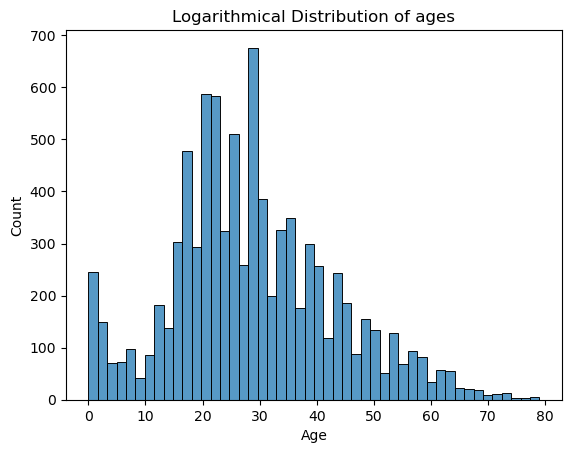

In [3]:
# developing a histogram using HISTPLOT
sns.histplot(data   = titanic_train, # Assigning the data source
             x      = 'Age', # Assigning the histoplot's x-axis 
             kde    = False)


# title and axis labels
plt.title(label   = "Logarithmical Distribution of ages") # Defining Title 
plt.xlabel(xlabel = "Age") # Assigning labels
plt.ylabel(ylabel = "Count") # Assigning labels

# displaying the histogram
plt.show()

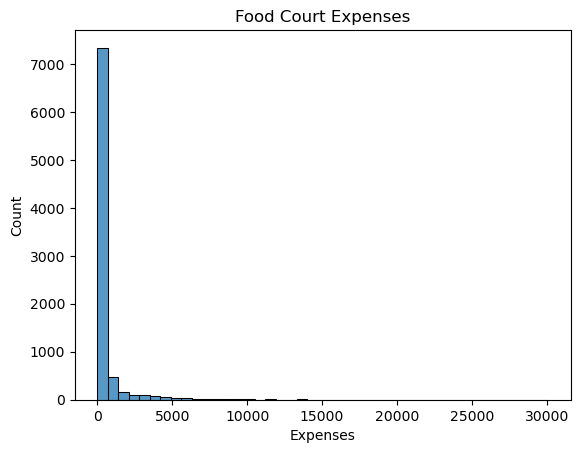

In [4]:
# developing a histogram using HIS3PLOT
sns.histplot(data   = titanic_train, # Assigning the data source
             x      = 'FoodCourt', # Assigning the histoplot's x-axis 
             kde    = False, 
             binwidth=700)


# title and axis labels
plt.title(label   = "Food Court Expenses") # Defining Title 
plt.xlabel(xlabel = "Expenses") # Assigning labels
plt.ylabel(ylabel = "Count") # Assigning labels

# displaying the histogram
plt.show()

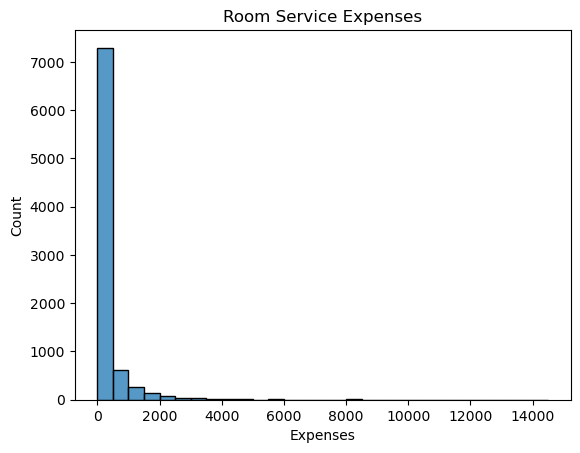

In [5]:
# Create a histogram of RoomService expenses
sns.histplot(data=titanic_train, 
             x='RoomService', 
             kde=False, 
             binwidth=500)

# Add title and axis labels
plt.title(label="Room Service Expenses")
plt.xlabel(xlabel="Expenses")
plt.ylabel(ylabel="Count")

# Display the histogram
plt.show()

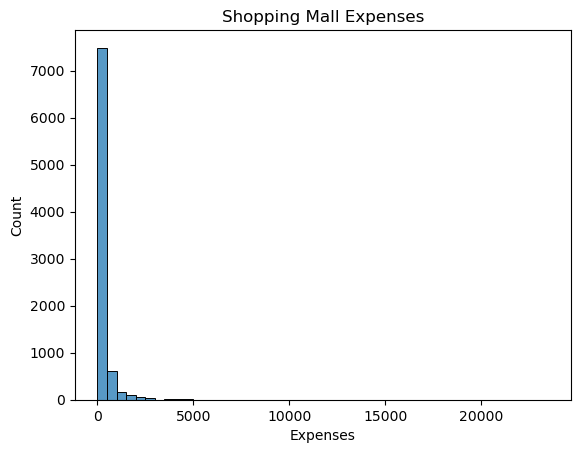

In [6]:
# developing a histogram using HISTPLOT
sns.histplot(data   = titanic_train, # Assigning the data source
             x      = 'ShoppingMall', # Assigning the histoplot's x-axis 
             kde    = False, 
             binwidth=500)


# title and axis labels
plt.title(label   = "Shopping Mall Expenses") # Defining Title 
plt.xlabel(xlabel = "Expenses") # Assigning labels
plt.ylabel(ylabel = "Count") # Assigning labels

# displaying the histogram
plt.show()

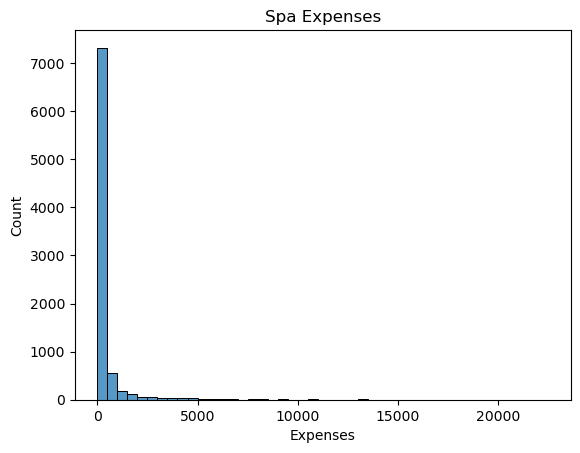

In [7]:
# developing a histogram using HISTPLOT
sns.histplot(data   = titanic_train, # Assigning the data source
             x      = 'Spa', # Assigning the histoplot's x-axis 
             kde    = False, 
             binwidth=500)


# title and axis labels
plt.title(label   = "Spa Expenses") # Defining Title 
plt.xlabel(xlabel = "Expenses") # Assigning labels
plt.ylabel(ylabel = "Count") # Assigning labels

# displaying the histogram
plt.show()

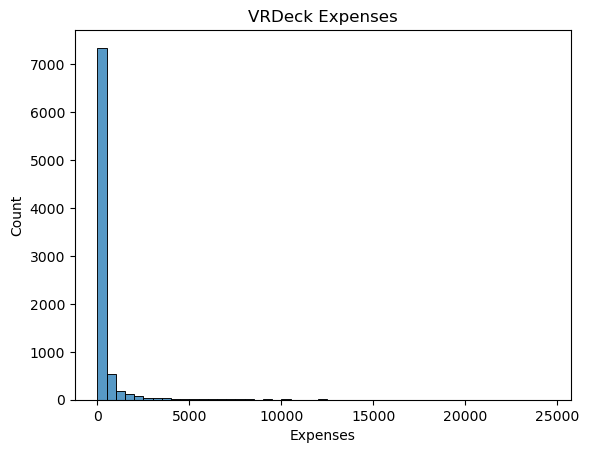

In [8]:
# developing a histogram using HISTPLOT
sns.histplot(data   = titanic_train, # Assigning the data source
             x      = 'VRDeck', # Assigning the histoplot's x-axis 
             kde    = False, 
             binwidth=500)


# title and axis labels
plt.title(label   = "VRDeck Expenses") # Defining Title 
plt.xlabel(xlabel = "Expenses") # Assigning labels
plt.ylabel(ylabel = "Count") # Assigning labels

# displaying the histogram
plt.show()

In [9]:
# Value_Counts  

print(f"""\n\n ------------------- Value_Counts - 'TotalExp_18plus' ------------------- \n\n""")

value_counts = titanic_train['TotalExp_18plus'].value_counts(normalize=True).head(20)
# Thesecond column indicates that i.e. there are 0.006212% of passengers who have TotalExp_18plus value of 0.523625
print(value_counts)


print(f"""\n\n ------------------- DESCRIBE - 'TotalExp_18plus' ------------------- \n\n""")

# Getting the stats of this variable

titanic_train['TotalExp_18plus'].describe()





 ------------------- Value_Counts - 'TotalExp_18plus' ------------------- 


0.000000    0.420223
0.118483    0.006212
0.115407    0.004601
0.117750    0.004486
0.117604    0.003911
0.132835    0.003681
0.132982    0.003681
0.115847    0.003451
0.130053    0.003336
0.104862    0.003106
0.115261    0.002876
0.118629    0.002761
0.190100    0.002761
0.380492    0.002416
0.118336    0.002416
0.103105    0.002301
0.102958    0.002186
0.105009    0.002186
0.114821    0.001956
0.132103    0.001956
Name: TotalExp_18plus, dtype: float64


 ------------------- DESCRIBE - 'TotalExp_18plus' ------------------- 




count    8693.000000
mean        0.211023
std         0.410522
min         0.000000
25%         0.000000
50%         0.104862
75%         0.211043
max         5.270504
Name: TotalExp_18plus, dtype: float64

In [10]:
print(f"""\n\n ------------------- DESCRIBE - 'TotalExp_18minus' ------------------- \n\n""")

# Getting the stats of this variable

titanic_train['TotalExp_18minus'].describe()




 ------------------- DESCRIBE - 'TotalExp_18minus' ------------------- 




count    8693.000000
mean        0.932600
std         1.814269
min         0.000000
25%         0.000000
50%         0.463430
75%         0.932686
max        23.292557
Name: TotalExp_18minus, dtype: float64

In [11]:

print(f"""\n\n ------------------- DESCRIBE - 'TotalExp_45plus' ------------------- \n\n""")

# Getting the stats of this variable

titanic_train['TotalExp_45plus'].describe()




 ------------------- DESCRIBE - 'TotalExp_45plus' ------------------- 




count    8693.000000
mean        1.251839
std         2.435313
min         0.000000
25%         0.000000
50%         0.622068
75%         1.251955
max        31.265856
Name: TotalExp_45plus, dtype: float64

In [12]:
print(f"""\n\n ------------------- DESCRIBE - 'TotalExp_45plus' ------------------- \n\n""")

# Getting the stats of this variable
titanic_train['TotalExp_Age34_65'].describe()



 ------------------- DESCRIBE - 'TotalExp_45plus' ------------------- 




count    8693.000000
mean        0.606170
std         1.179237
min         0.000000
25%         0.000000
50%         0.301220
75%         0.606226
max        15.139672
Name: TotalExp_Age34_65, dtype: float64

In [13]:
# Grouping by age groups 
grouped = titanic_train.groupby(['TotalExp_Age34_65', 'TotalExp_18minus', 'TotalExp_18plus'])


In [14]:
# Defining a dictionary of aggregate functions to be applied to each column
agg_funcs = {'TotalExp_Age34_65': ['mean', 'sum'], 'TotalExp_18minus': 'max', 'TotalExp_18plus': 'min'}

# Appling the aggregate functions to each group using the grouped object and store the results in a new dataframe
agg_results = grouped.agg(agg_funcs)

print(agg_results)


                                                   TotalExp_Age34_65            TotalExp_18minus TotalExp_18plus
                                                                mean        sum              max             min
TotalExp_Age34_65 TotalExp_18minus TotalExp_18plus                                                              
0.000000          0.000000         0.000000                 0.000000   0.000000         0.000000        0.000000
0.000421          0.000647         0.000146                 0.000421   0.000841         0.000647        0.000146
0.000841          0.001294         0.000293                 0.000841   0.000841         0.001294        0.000293
0.001683          0.002589         0.000586                 0.001683   0.001683         0.002589        0.000586
0.003366          0.005178         0.001172                 0.003366   0.003366         0.005178        0.001172
...                                                              ...        ...              ...

<AxesSubplot:>

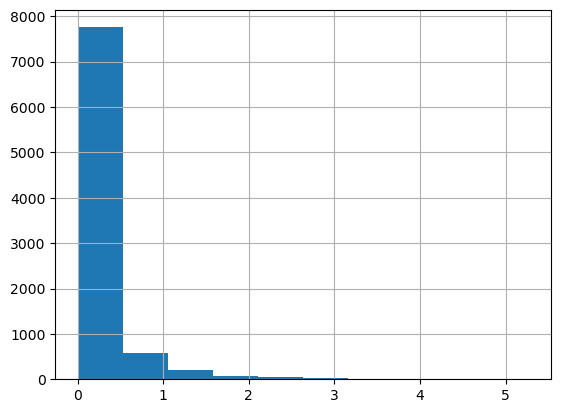

In [15]:
titanic_train['TotalExp_18plus'].hist()

# Age groups & Total expenses Boxplot explained

Regarding the feature engineered mentioned before of “18+ year-olds/total expenditure”, as seen in this boxplot, the group that spent the most are 45+ year-old passengers, while this one is followed by under-aged passengers (18- year-olds).  
This goes against what the US Bureau of labor Statistics claims, since according to their 2017 report, 35 - 64 year-olds are the group that spends the most except for alcohol, healthcare, and cash payments (U.S. Bureau of Labor Statistics, 2017). 

Also, it can be observed there are many outliers for each of the age groups, for example, in the age group of 34 - 65 year-olds, there are 378 potential outliers, which means there are 378 people not part of the group that spend 50% of the total expenditure of a total of 8,693 in this age group, which represents a 4.34%. Having this in mind, we can conclude the group that spent the most is 45+ year-olds, because of their disposable income, as well as for probably having to financially support their family members. 

Also, as explained later in the report, this feature engineered is the strongest when it comes to its importance in predicting transported passengers, we can infer that while being 18+ years-old, the more money spent on amenities, which is probably coming from a wealthier family or having a larger disposable income has a great impact on being transported. 


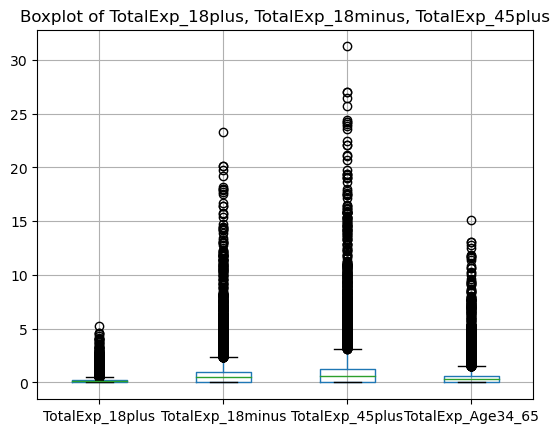

In [16]:
import matplotlib.pyplot as plt

# Select the columns you want to plot
cols = ['TotalExp_18plus', 'TotalExp_18minus', 'TotalExp_45plus', 'TotalExp_Age34_65']

# Create a boxplot of the selected columns
titanic_train[cols].boxplot()

# Set the title of the plot
plt.title('Boxplot of TotalExp_18plus, TotalExp_18minus, TotalExp_45plus')

# Show the plot
plt.show()

In [17]:
# Calculate the mean and standard deviation of the data
mean1 = np.mean(titanic_train['TotalExp_18plus'])
std1 = np.std(titanic_train['TotalExp_18plus'])

mean2 = np.mean(titanic_train['TotalExp_18minus'])    # mean 
std2 = np.std(titanic_train['TotalExp_18minus'])      # standard deviation 

mean3 = np.mean(titanic_train['TotalExp_45plus'])
std3 = np.std(titanic_train['TotalExp_45plus'])

mean4 = np.mean(titanic_train['TotalExp_Age34_65'])   # mean
std4 = np.std(titanic_train['TotalExp_Age34_65'])     # standard deviation 

# Calculate the z-score for each data point
z_scores1 = (titanic_train['TotalExp_18plus'] - mean1) / std1

z_scores2 = (titanic_train['TotalExp_18minus'] - mean2) / std2

z_scores3 = (titanic_train['TotalExp_45plus'] - mean3) / std3

z_scores4 = (titanic_train['TotalExp_Age34_65'] - mean4) / std4


# Count the data points that are 2 standard deviations away from the mean
count18plus = len(np.where(np.abs(z_scores1) >= 2)[0])

count18minus = len(np.where(np.abs(z_scores2) >= 2)[0])

count45plus = len(np.where(np.abs(z_scores3) >= 2)[0])

count34_65 = len(np.where(np.abs(z_scores4) >= 2)[0])

# Printing the count of the outliers for each age group defined above 
print(f"Number of data points that are 2 standard deviations away from the mean: {count18plus}")
print(f"Number of data points that are 2 standard deviations away from the mean: {count18minus}")
print(f"Number of data points that are 2 standard deviations away from the mean: {count45plus}")
print(f"Number of data points that are 2 standard deviations away from the mean: {count34_65}")

Number of data points that are 2 standard deviations away from the mean: 378
Number of data points that are 2 standard deviations away from the mean: 378
Number of data points that are 2 standard deviations away from the mean: 378
Number of data points that are 2 standard deviations away from the mean: 378


In [18]:
# outliers34_65 = count34_65 

titanic_train['TotalExp_Age34_65'].value_counts().sum()


# final = count_34_65 - outliers34_65

# print(final)

8693

In [19]:
# titanic_train[['TotalExp_18plus']][np.abs(z_scores) >= 2]

In [20]:
### This shows us the expenditure for people over 18 years old 
titanic_train['TotalExp_18plus'].head(10)

0    0.000000
1    0.107791
2    1.520650
3    0.758055
4    0.159783
5    0.113357
6    0.231986
7    0.000000
8    0.149092
9    0.000000
Name: TotalExp_18plus, dtype: float64

In [21]:
# Displaying the x var variables
x_var

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported',
 'group',
 'is_solo',
 'HomePlanet_Europa',
 'HomePlanet_Earth',
 'HomePlanet_Mars',
 'CryoSleep_True',
 'CryoSleep_False',
 'Cabin_P',
 'Cabin_S',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Destination_55_Cancri_e',
 'Destination_PSO_J318_5_22',
 'Destination_TRAPPIST_1e',
 'Total_expenses',
 'amenities_use',
 'LOG_RoomServiceF',
 'LOG_FoodCourtF',
 'LOG_ShoppingMallF',
 'LOG_SpaF',
 'LOG_VRDeckF',
 'LOG_Total_expenses',
 'out_LOG_RoomServiceF_lo',
 'out_LOG_FoodCourtF_lo',
 'out_LOG_ShoppingMallF_lo',
 'out_LOG_SpaF_lo',
 'out_LOG_VRDeckF_lo',
 'out_LOG_Total_expenses_lo',
 'LOG_Age',
 'out_LOG_Age_lo',
 'Age<18',
 'Age>18',
 'Age>45',
 'Age>35<64',
 'TotalExp_18plus',
 'TotalExp_18minus',
 'TotalExp_45plus',
 'TotalExp_Age34_65',
 'sleep_cabin_ratio']

In [22]:
# Selecting the variables 
titanic_train = titanic_train[[
 'group',
 'is_solo',
 'HomePlanet_Europa',
 'HomePlanet_Earth',            # HomePlanet_Earth variable added
 'HomePlanet_Mars',
 'CryoSleep_True',
 'CryoSleep_False',
 'Cabin_P',                     # Cabin_p variable added 
 'Cabin_S',
 'Destination_55_Cancri_e',
 'Destination_PSO_J318_5_22',
 'Destination_TRAPPIST_1e',
 'Total_expenses',              # Total_expenses variable added
 'amenities_use',
 'LOG_RoomServiceF',
 'LOG_FoodCourtF',
 'LOG_ShoppingMallF',
 'LOG_SpaF',                   # LOG_SpaF variable added
 'LOG_VRDeckF',
 'LOG_Total_expenses',
 'out_LOG_RoomServiceF_lo',
 'out_LOG_FoodCourtF_lo',
 'out_LOG_ShoppingMallF_lo',  # out_LOG_ShoppingMallF_lo variable added
 'out_LOG_SpaF_lo',
 'out_LOG_VRDeckF_lo',
 'out_LOG_Total_expenses_lo',
 'LOG_Age',
 'out_LOG_Age_lo',            # out_LOG_Age_lo variable added
 'Age>18',
 'TotalExp_18plus',
 'sleep_cabin_ratio','Transported']]

for columns in titanic_train : # Printing all our variables and a plus sign right next to each of them 
    print(columns,'+')

group +
is_solo +
HomePlanet_Europa +
HomePlanet_Earth +
HomePlanet_Mars +
CryoSleep_True +
CryoSleep_False +
Cabin_P +
Cabin_S +
Destination_55_Cancri_e +
Destination_PSO_J318_5_22 +
Destination_TRAPPIST_1e +
Total_expenses +
amenities_use +
LOG_RoomServiceF +
LOG_FoodCourtF +
LOG_ShoppingMallF +
LOG_SpaF +
LOG_VRDeckF +
LOG_Total_expenses +
out_LOG_RoomServiceF_lo +
out_LOG_FoodCourtF_lo +
out_LOG_ShoppingMallF_lo +
out_LOG_SpaF_lo +
out_LOG_VRDeckF_lo +
out_LOG_Total_expenses_lo +
LOG_Age +
out_LOG_Age_lo +
Age>18 +
TotalExp_18plus +
sleep_cabin_ratio +
Transported +


In [23]:
import statsmodels.formula.api as smf                # logistic regression

# instantiating a logistic regression model object
logistic_full = smf.logit(formula   = """ Transported   ~  is_solo +
                                                            HomePlanet_Europa +
                                                            HomePlanet_Earth +
                                                            HomePlanet_Mars +
                                                            CryoSleep_True +
                                                            Cabin_P +
                                                            Destination_55_Cancri_e +
                                                            Destination_PSO_J318_5_22 +
                                                            Destination_TRAPPIST_1e +
                                                            Total_expenses +
                                                            amenities_use +
                                                            LOG_RoomServiceF +
                                                            LOG_FoodCourtF +
                                                            LOG_ShoppingMallF +
                                                            LOG_SpaF +
                                                            LOG_VRDeckF +
                                                            LOG_Total_expenses +
                                                            out_LOG_RoomServiceF_lo +
                                                            out_LOG_FoodCourtF_lo +
                                                            out_LOG_ShoppingMallF_lo +
                                                            out_LOG_SpaF_lo +
                                                            out_LOG_VRDeckF_lo +
                                                            out_LOG_Total_expenses_lo +
                                                            LOG_Age +
                                                            out_LOG_Age_lo +
                                                            TotalExp_18plus +
                                                            sleep_cabin_ratio""",
                                                         data = titanic_train) # setting train data as our data source


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

         Current function value: 0.464707
         Iterations: 35


C:\Users\bromi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
=========================================================================================
Model:                       Logit                    Pseudo R-squared:         0.330    
Dependent Variable:          Transported              AIC:                      8133.3964
Date:                        2023-03-11 17:47         BIC:                      8324.2938
No. Observations:            8693                     Log-Likelihood:           -4039.7  
Df Model:                    26                       LL-Null:                  -6025.3  
Df Residuals:                8666                     LLR p-value:              0.0000   
Converged:                   0.0000                   Scale:                    1.0000   
No. Iterations:              35.0000                                                     
-----------------------------------------------------------------------------------------
                           Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
-----------------------------------------------------------------------------------------
Intercept                  2.3509          nan      nan    nan           nan          nan
is_solo                    0.0052       0.0614   0.0848 0.9325       -0.1151       0.1256
HomePlanet_Europa          1.2649       0.2028   6.2382 0.0000        0.8675       1.6623
HomePlanet_Earth          -0.5655       0.1846  -3.0639 0.0022       -0.9273      -0.2038
HomePlanet_Mars            0.1092       0.1925   0.5674 0.5704       -0.2681       0.4866
CryoSleep_True             1.0862       0.1116   9.7346 0.0000        0.8675       1.3049
Cabin_P                   -0.5367       0.0556  -9.6510 0.0000       -0.6457      -0.4277
Destination_55_Cancri_e    0.0089       0.2044   0.0435 0.9653       -0.3917       0.4095
Destination_PSO_J318_5_22 -0.3404       0.2123  -1.6038 0.1088       -0.7564       0.0756
Destination_TRAPPIST_1e   -0.4110       0.1958  -2.0990 0.0358       -0.7947      -0.0272
Total_expenses            -0.0000     404.9715  -0.0000 1.0000     -793.7296     793.7295
amenities_use             -0.0122       0.3628  -0.0338 0.9731       -0.7233       0.6988
LOG_RoomServiceF          -0.3958       0.0368 -10.7628 0.0000       -0.4679      -0.3237
LOG_FoodCourtF             0.3595       0.0377   9.5456 0.0000        0.2857       0.4334
LOG_ShoppingMallF          0.3059       0.0365   8.3907 0.0000        0.2345       0.3774
LOG_SpaF                  -0.4654       0.0336 -13.8387 0.0000       -0.5313      -0.3995
LOG_VRDeckF               -0.4201       0.0340 -12.3567 0.0000       -0.4867      -0.3535
LOG_Total_expenses        -0.1641       0.0875  -1.8762 0.0606       -0.3355       0.0073
out_LOG_RoomServiceF_lo   -1.2816       0.1913  -6.6993 0.0000       -1.6566      -0.9067
out_LOG_FoodCourtF_lo      1.4259       0.2081   6.8530 0.0000        1.0181       1.8337
out_LOG_ShoppingMallF_lo   1.3238       0.1989   6.6549 0.0000        0.9339       1.7136
out_LOG_SpaF_lo           -1.3898       0.1717  -8.0923 0.0000       -1.7264      -1.0532
out_LOG_VRDeckF_lo        -1.2149       0.1756  -6.9191 0.0000       -1.5591      -0.8708
out_LOG_Total_expenses_lo -1.0317       0.6454  -1.5984 0.1099       -2.2967       0.2333
LOG_Age                   -0.1253       0.0339  -3.6989 0.0002       -0.1918      -0.0589
out_LOG_Age_lo            -0.0103       0.1650  -0.0625 0.9502       -0.3337       0.3130
TotalExp_18plus           -0.0000 2765145.2874  -0.0000 1.0000 -5419585.1754 5419585.1754
sleep_cabin_ratio          1.6975          nan      nan    nan           nan          nan
=========================================================================================

"""

In [24]:
# Selecting features for train data
x_train = titanic_train[[
 'is_solo',                     # Varibale added
 'HomePlanet_Europa',           # Varibale added
 'HomePlanet_Earth',            # Varibale added
 'CryoSleep_True',              # Varibale added
 'Cabin_P',                     # Varibale added
 'Destination_55_Cancri_e',     # Varibale added
 'Destination_TRAPPIST_1e',     # Varibale added
 'amenities_use',               # Varibale added
 'LOG_RoomServiceF',            # Varibale added
 'LOG_FoodCourtF',              # Varibale added
 'LOG_ShoppingMallF',           # Varibale added
 'LOG_SpaF',                    # Varibale added
 'LOG_VRDeckF',                 # Varibale added
 'LOG_Total_expenses',          # Varibale added
 'out_LOG_RoomServiceF_lo',     # Varibale added
 'out_LOG_FoodCourtF_lo',       # Varibale added
 'out_LOG_ShoppingMallF_lo',    # Varibale added
 'out_LOG_SpaF_lo',             # Varibale added
 'out_LOG_VRDeckF_lo',          # Varibale added
 'out_LOG_Total_expenses_lo',   # Varibale added
 'LOG_Age',                     # Varibale added
 'out_LOG_Age_lo',              # Varibale added
 'TotalExp_18plus',             # Varibale added
 'sleep_cabin_ratio'            # Varibale added
]]

# Selecting target variable for training data
y_train = titanic_train[ 'Transported' ]

# developing training and validation sets
x_train_1, x_train_2, y_train_1, y_train_2 = train_test_split(
            x_train,
            y_train,
            random_state = 123,   # Random State set at 123
            test_size    = 0.25,
            stratify     = y_train)

In [25]:
# x_train = titanic_train[[
#     'HomePlanet_Europa',
#     'HomePlanet_Earth',
#     'CryoSleep_True',
#     'Cabin_P',
#     'Destination_55_Cancri_e',
#     'Destination_TRAPPIST_1e',
#     'LOG_RoomServiceF',
#     'LOG_FoodCourtF',
#     'LOG_ShoppingMallF',
#     'LOG_SpaF',
#     'LOG_VRDeckF',
#     'LOG_Total_expenses',
#     'amenities_use',
#     'LOG_Age'
# ]]

# y_train = titanic_train[ 'Transported' ]

# # developing training and validation sets
# x_train_1, x_train_2, y_train_1, y_train_2 = train_test_split(
#             x_train,
#             y_train,
#             random_state = 123,
#             test_size    = 0.25,
#             stratify     = y_train)

# DecisionTreeClassifier

Below is the result of the DecisionTreeClassifier's accuracy scores. As seen, the testing accuracy is only 0.75, which gives it room of improvement, when compared to our best model which sets at 0.80, with a low train-test gap of 0.02. 

Although the result is not high, the model can provide a plot tree to understand the logic of prediction in terms of which variables and how much influence the prediction is transported or not. 

By following low entropy nodes, it gives us the logic of what this prediction consists of. Features such as TotalExp_18Plus, HomePlanet, Age strongly contributed to this prediction. 

In [26]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
dtc = sklearn.tree.DecisionTreeClassifier(random_state = 123,
                                          splitter = 'best',
                                          min_samples_leaf = 30,
                                          max_features = 'sqrt',
                                          criterion = 'entropy',
                                          max_depth = 7,
                                          min_samples_split = 4)


# FITTING to the training data
model_fit = dtc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = dtc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = dtc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.7744
Testing Accuracy : 0.7521


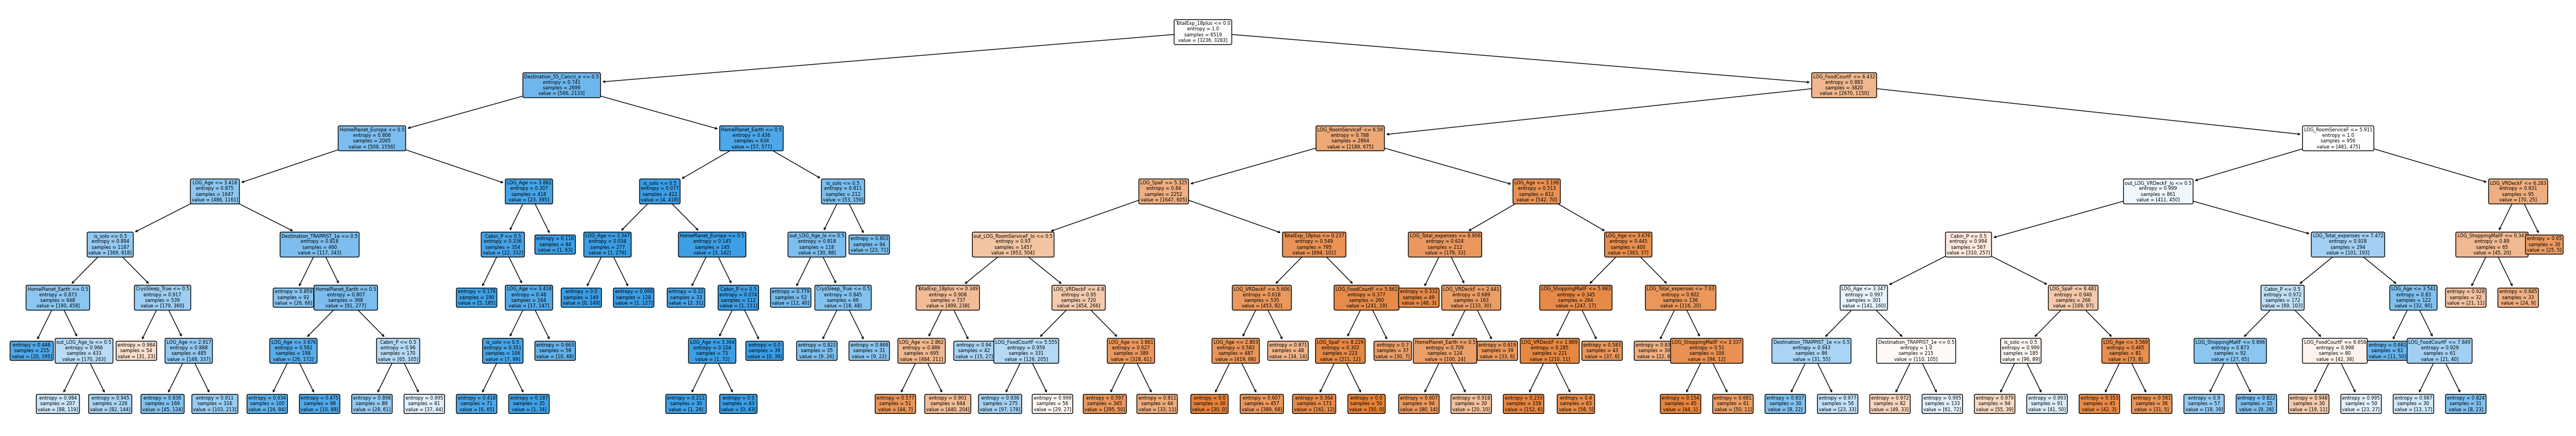

In [27]:
# setting figure size
plt.figure(figsize=(60, 10)) # adjusting to better fit the visual


# developing a plotted tree
sklearn.tree.plot_tree(decision_tree = dtc, # changing to pruned_tree_fit
          feature_names = x_train.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 6)

# rendering the plot
plt.show()

In [28]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
etc = sklearn.tree.ExtraTreeClassifier(random_state = 123,
                                          max_depth = 8,
                                          min_samples_split = 61)


# FITTING to the training data
model_fit = etc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = etc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = etc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.7586
Testing Accuracy : 0.758


In [29]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
sgdc = sklearn.linear_model.SGDClassifier(random_state = 123)


# FITTING to the training data
model_fit = sgdc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = sgdc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = sgdc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.7728
Testing Accuracy : 0.7797


In [30]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
gbc = sklearn.ensemble.GradientBoostingClassifier(random_state = 123,
                                                  n_estimators=95,
                                                 learning_rate=0.1,
                                                 max_depth=4,
                                                 min_samples_split=10,
                                                 max_features=0.5,
                                                 subsample=0.8,
                                                 loss='deviance',
                                                 warm_start=True)


# FITTING to the training data
model_fit = gbc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = gbc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = gbc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.8221
Testing Accuracy : 0.7981


In [31]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
rc = sklearn.linear_model.RidgeClassifier(random_state = 123,alpha=1.96)


# FITTING to the training data
model_fit = rc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = rc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = rc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.7851
Testing Accuracy : 0.7884


In [32]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
lr = sklearn.linear_model.LogisticRegression(random_state = 123, C=0.1)


# FITTING to the training data
model_fit = lr.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = lr.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = lr.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.7863
Testing Accuracy : 0.7866


C:\Users\bromi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=25)


# FITTING to the training data
model_fit = knn.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = knn.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = knn.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

C:\Users\bromi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\bromi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Training Accuracy: 0.8
Testing Accuracy : 0.7893


C:\Users\bromi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [34]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
abc = sklearn.ensemble.AdaBoostClassifier(random_state = 123)


# FITTING to the training data
model_fit = abc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = abc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = abc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.7992
Testing Accuracy : 0.7921


In [35]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
bc = sklearn.ensemble.BaggingClassifier(random_state = 123,
                                        n_estimators = 98)


# FITTING to the training data
model_fit = bc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = bc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = bc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.9528
Testing Accuracy : 0.7806


# Model: RandomForestClassifier

This model used the available data to make predictions about whether a passenger was transported by the anomaly or not using the Random Forest Classifier algorithm.

The training accuracy score for this model is 0.7975, which means that the model was able to correctly predict the outcome for 79.75% of the training data. The testing (or validation) accuracy score is 0.7852, indicating that the model was able to correctly predict the outcome for 78.52% of the validation data.

These accuracy scores suggest that the model is performing relatively well.

However, these accuracy scores alone do not provide much insight into the effectiveness of the model. A more informative analysis would involve examining the confusion matrix of the model, which shows the number of true positives, true negatives, false positives, and false negatives. 

Overall, while the accuracy scores may seem low, it is important to consider the complexity of the problem and the limited information available. 


In [36]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
rfc = sklearn.ensemble.RandomForestClassifier(random_state = 123,     # Random State set at 123
                                              n_estimators = 50,      # n_estimators set at 50
                                              max_depth = 7,          # max_depth set at 7
                                              min_samples_leaf = 36)  # min_samples_leaf set at 36


# FITTING to the training data
model_fit = rfc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = rfc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = rfc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

Training Accuracy: 0.7975
Testing Accuracy : 0.7852


# Model: HistGradientBoostingClassifier 

The Hist Gradient Boosting Classifier is one of the models used in our analysis. Without getting too much on the technical side, this model uses weaker ones such as decision trees while using different bins to process data at a much faster and energy efficient way. 

In this case, as seen below, our Training Accuracy and our testing Accuracy are 0.83 and 0.8 respectively. Being conservative, this means there is an 80% chance the features taken into account but especially the most significant ones, such as wealthier 18+ year-olds are more likely to get transported, the same happens with passengers coming from both planets/moons, Earth and Europa. But still, even though the percentage of predicting passengers with these characteristics being transported is quite high (80%), there is still a 20% chance of creating wrong predictions. 

Also, since the gap between training (iterated data) and testing (new data), 0.03,  is very small and within the limit of 0.5, this reinforces the validity of our prediction.  


In [37]:
# INSTANTIATING a model object - CHANGE THIS AS NEEDED
hgbc = sklearn.ensemble.HistGradientBoostingClassifier(random_state = 123, max_iter=46)


# FITTING to the training data
model_fit = hgbc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = hgbc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = hgbc.score(x_train_2, y_train_2).round(4) # validation accuracy

GAP_hgbc =  model_train_score - model_valid_score

# displaying results
print('Training Accuracy:', model_train_score)      # Printing Training Accuracy 
print('Testing Accuracy :', model_valid_score)      # Printing Testing Accuracy 
print(f"""Train-test GAP : {GAP_hgbc.round(4)}""")  # Printing Gap 

Training Accuracy: 0.8299
Testing Accuracy : 0.8036
Train-test GAP : 0.0263


## Plot explain: HistGBC Learning Curve

The learning curve plot of a HistGradientBoostingClassifier shows how the training and cross validation scores of the classifier change as the size of the training set increases. The x-axis of the plot shows the size of the training set, and the y-axis shows the score, which is a measure of how well the classifier is performing. The red line on the plot shows the training score, which represents how well the classifier fits the training data. The green line shows the cross validation score, which represents how well the classifier generalizes to new data. 

By looking at the learning curve, you can see the classifier is underfitting the data. This implies that the model can be improved by adding more features.

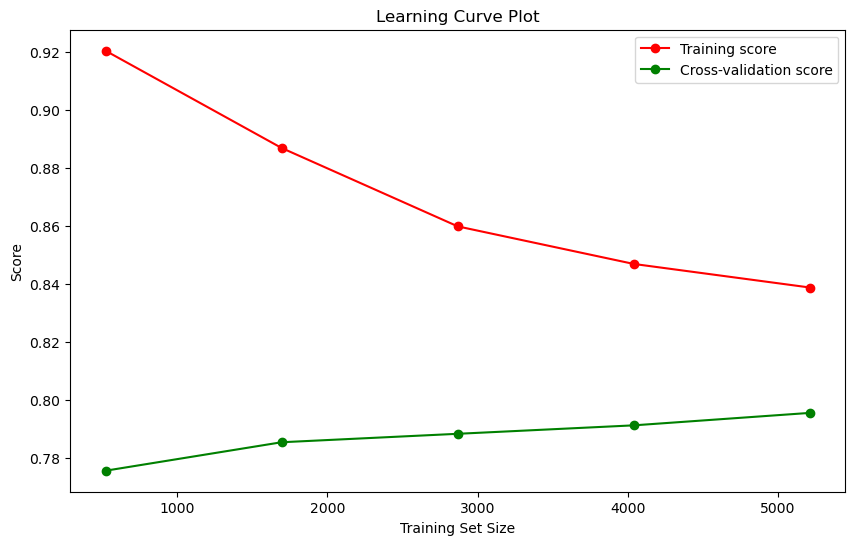

In [38]:
# import the library for learning_curve
from sklearn.model_selection import learning_curve

# compute learning curves for a HistGradientBoostingClassifier
train_sizes, train_scores, test_scores = learning_curve(hgbc, x_train_1, y_train_1, cv=5)

# calculate the mean of the training scores across all cross validation folds for each training set size
train_scores_mean = np.mean(train_scores, axis=1)

# calculate the mean of the validation scores across all cross validation folds for each training set size
test_scores_mean = np.mean(test_scores, axis=1)

# create a plot of the learning curve
# set the figsize
plt.figure(figsize=(10, 6))

# plot the training score as a function of the training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')

# plot the cross validation score as a function of the training set size
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# label the graph
plt.xlabel('Training Set Size')      # label the x-axis
plt.ylabel('Score')                  # label the y-axis
plt.title('Learning Curve Plot')     # add a title to the plot
plt.legend(loc='best')               # add a legend to the plot

plt.show()  # show the plot


# Model: StackingClassifier

The StackingClassifier is a machine learning technique that combines the predictions of multiple models to make more accurate predictions. Think of it like a committee where each member has a different opinion, but together they come up with the best decision. 

A high training accuracy score means that the model is doing a good job at predicting the outcomes of the data that it has been trained on. A high validation accuracy score means that the model is doing a good job at predicting the outcomes of new data that it hasn't seen before.

Therefore, the outputs of the StackingClassifier in your code, which show a training accuracy of 0.8259 and a validation accuracy of 0.8068, indicate that the model is performing reasonably well and has the potential to make accurate predictions on new data.


In [39]:
estimators = [
        # ('dtc', dtc), 
        # ('etc', etc), 
        ('rc', rc),        # rc model
        ('lr', lr),        # lr model
        # ('sgdc', sgdc), 
        ('knn', knn),      # KNN model
        ('gbc', gbc),      # gbc model
        ('abc', abc),      # abc model
        ('bc', bc),        # bc model
        ('rfc', rfc),      # rfc model
        ('hgbc', hgbc)     # hgbc model
]

# INSTANTIATING a model object - CHANGE THIS AS NEEDED
sc = sklearn.ensemble.StackingClassifier(estimators=estimators,   
                                         final_estimator=rfc, 
                                         cv=5)                  # cv set at 5


# FITTING to the training data
model_fit = sc.fit(x_train_1, y_train_1)


# PREDICTING on the response variable
model_train_pred = model_fit.predict(x_train_1)
model_valid_pred = model_fit.predict(x_train_2)


# SCORING the results (accuracy)
model_train_score = sc.score(x_train_1, y_train_1).round(4) # training accuracy
model_valid_score = sc.score(x_train_2, y_train_2).round(4) # validation accuracy


# displaying results
print('Training Accuracy:', model_train_score)
print('Testing Accuracy :', model_valid_score)

C:\Users\bromi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\bromi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Training Accuracy: 0.8259
Testing Accuracy : 0.8063


In [40]:
# importing the training dataset
path             = "./spaceship-titanic/"
testing_dataset = "test.csv"

# reading in the .csv file with pandas
titanic_test    = pd.read_csv(filepath_or_buffer = path + testing_dataset)
########################################################################################################
# PassengerId
titanic_test['group'] = titanic_test['PassengerId'].str.split('_').str[0]
group_counts = titanic_test['group'].value_counts()
titanic_test['is_solo'] = titanic_test['group'].apply(lambda x: 1 if group_counts[x] == 1 else 0)
########################################################################################################
# HomePlanet
# Adding new columns to the 'titanic_test' dataframe to store binary values indicating passengers' home planet
titanic_test['HomePlanet_Europa'] = 0    # HomePlanet_Europa
titanic_test['HomePlanet_Earth'] = 0     # HomePlanet_Earth
titanic_test['HomePlanet_Mars'] = 0      # HomePlanet_Mars

for index, value in enumerate(titanic_test['HomePlanet']):
    if value == 'Europa':
        titanic_test.loc[index, 'HomePlanet_Europa'] = 1 # Set the value of 'HomePlanet_Europa' to 1 if the value of 'HomePlanet' is 'Europa'
    elif value == 'Earth':
        titanic_test.loc[index, 'HomePlanet_Earth'] = 1  # Set the value of 'HomePlanet_Earth' to 1 if the value of 'HomePlanet' is 'Earth'
    elif value == 'Mars':
        titanic_test.loc[index, 'HomePlanet_Mars'] = 1   # Set the value of 'HomePlanet_Mars' to 1 if the value of 'HomePlanet' is 'Mars'
    elif pd.isna(value) == True:
        pass
    else:
        print('Error', index, value) # Print an error message if the value of 'HomePlanet' is not one of the expected values
########################################################################################################
# CryoSleep
# Adding new columns for CryoSleep_True and CryoSleep_False
titanic_test['CryoSleep_True'] = 0
titanic_test['CryoSleep_False'] = 0

 # Looping through the values of 'CryoSleep' and assigning 1 to the respective column based on the condition
for index, value in enumerate(titanic_test['CryoSleep']):
    if value == True:
        titanic_test.loc[index, 'CryoSleep_True'] = 1  # if the 'CryoSleep' feature is True, encode 1 in 'CryoSleep_True' column of the same row
    elif value == False:
        titanic_test.loc[index, 'CryoSleep_False'] = 1 # if the 'CryoSleep' feature is False, encode 1 in 'CryoSleep_False' column of the same row
    elif pd.isna(value) == True:
        pass
    else:
        print('Error', index, value) # print an error message if the value is not True, False or NaN
########################################################################################################
# Cabin P/S
# Create new columns for each cabin type with default value of 0
titanic_test['Cabin_P'] = 0
titanic_test['Cabin_S'] = 0

for index, value in enumerate(titanic_test['Cabin']):
    if str(value)[-1] == 'P':
        titanic_test.loc[index, 'Cabin_P'] = 1  # if the last character in the cabin value is 'S', set 'Cabin_S' column to 1
    elif str(value)[-1] == 'S':
        titanic_test.loc[index, 'Cabin_S'] = 1
    elif pd.isna(value) == True:
        pass
    else:                                       # if none of the above, print an error message with the index and value
        print('Error', index, value)
########################################################################################################
# Destination
# Convert destination column to dummies variables
destinarion_dummies = pd.get_dummies(titanic_test['Destination'], prefix='Destination')
# Concatenate the dummies variables to the test dataframe
titanic_test = pd.concat([titanic_test, destinarion_dummies], axis=1)

# Renaming destination variables
titanic_test['Destination_55_Cancri_e'] = titanic_test['Destination_55 Cancri e']
titanic_test['Destination_PSO_J318_5_22'] = titanic_test['Destination_PSO J318.5-22']
titanic_test['Destination_TRAPPIST_1e'] = titanic_test['Destination_TRAPPIST-1e']
########################################################################################################
# Amenities
missing_col = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i in missing_col:
    titanic_test.loc[titanic_test.loc[:,i].isnull(),i]=titanic_test.loc[:,i].median()

# Total_expenses
titanic_test['Total_expenses'] = titanic_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# amenities_use
titanic_test['amenities_use'] = 0
for index, row in titanic_test.iterrows():
    
    # If any of the amenities have a value greater than 1, set amenities_use to 1
    if titanic_test.loc[index, 'RoomService'] > 1\
            or titanic_test.loc[index, 'FoodCourt'] > 1\
            or titanic_test.loc[index, 'ShoppingMall'] > 1\
            or titanic_test.loc[index, 'Spa'] > 1\
            or titanic_test.loc[index, 'Spa'] > 1:
        titanic_test.loc[index, 'amenities_use'] = 1  # Seting 'amenities_use' column to 1 for the row where at least one of the amenities is used more than once.

# Logged Amenities
titanic_test['LOG_RoomServiceF'] = np.log(titanic_test['RoomService'] +1)       # Log transforming feature
titanic_test['LOG_FoodCourtF'] = np.log(titanic_test['FoodCourt'] +1)           # Log transforming feature
titanic_test['LOG_ShoppingMallF'] = np.log(titanic_test['ShoppingMall'] +1)     # Log transforming feature
titanic_test['LOG_SpaF'] = np.log(titanic_test['Spa'] +1)                       # Log transforming feature
titanic_test['LOG_VRDeckF'] = np.log(titanic_test['VRDeck'] +1)                 # Log transforming feature
titanic_test['LOG_Total_expenses'] = np.log(titanic_test['Total_expenses'] +1)  # Log transforming feature

# LOG_RoomServiceF outliers
titanic_test['out_LOG_RoomServiceF_lo'] = 0
for index, value in enumerate(titanic_test['LOG_RoomServiceF']):
    if value < 2:
        titanic_test.loc[index, 'out_LOG_RoomServiceF_lo'] = 1
        
# LOG_FoodCourtF outliers
titanic_test['out_LOG_FoodCourtF_lo'] = 0
for index, value in enumerate(titanic_test['LOG_FoodCourtF']):
    if value < 2:
        titanic_test.loc[index, 'out_LOG_FoodCourtF_lo'] = 1
        
# LOG_ShoppingMallF outliers
titanic_test['out_LOG_ShoppingMallF_lo'] = 0
for index, value in enumerate(titanic_test['LOG_ShoppingMallF']):
    if value < 2:
        titanic_test.loc[index, 'out_LOG_ShoppingMallF_lo'] = 1
        
# LOG_SpaF outliers
titanic_test['out_LOG_SpaF_lo'] = 0
for index, value in enumerate(titanic_test['LOG_SpaF']):
    if value < 2:
        titanic_test.loc[index, 'out_LOG_SpaF_lo'] = 1
        
# LOG_VRDeckF outliers
titanic_test['out_LOG_VRDeckF_lo'] = 0
for index, value in enumerate(titanic_test['LOG_VRDeckF']):
    if value < 2:
        titanic_test.loc[index, 'out_LOG_VRDeckF_lo'] = 1
        
# LOG_Total_expenses outliers
titanic_test['out_LOG_Total_expenses_lo'] = 0
for index, value in enumerate(titanic_test['LOG_Total_expenses']):
    if value < 2:
        titanic_test.loc[index, 'out_LOG_Total_expenses_lo'] = 1
########################################################################################################
# Age
missing_col = ['Age']
for i in missing_col:
    titanic_test.loc[titanic_test.loc[:,i].isnull(),i]=titanic_test.loc[:,i].mean()

# logged Age
titanic_test['Age'] = titanic_test['Age'].replace(0, 0.01)
titanic_test['LOG_Age'] = np.log(titanic_test['Age'])

# logged age outliers
titanic_test['out_LOG_Age_lo'] = 0
for index, value in enumerate(titanic_test['LOG_Age']):
    if value < 2:
        titanic_test.loc[index, 'out_LOG_Age_lo'] = 1

# Age>18
titanic_test['Age>18'] = np.where(titanic_test['Age'] < 18, 1, 0)

# TotalExp_18plus
titanic_test['TotalExp_18plus'] = titanic_test['Total_expenses'] / titanic_test['Age>18'].sum()
########################################################################################################
# fix Transported
########################################################################################################
# Cryosleep/cabin ratio
titanic_test['sleep_cabin_ratio'] = titanic_test['CryoSleep_True'].sum() / titanic_test['Cabin_P'].sum()
########################################################################################################
# printing results
for columns in titanic_test :
    print(columns,'+')

PassengerId +
HomePlanet +
CryoSleep +
Cabin +
Destination +
Age +
VIP +
RoomService +
FoodCourt +
ShoppingMall +
Spa +
VRDeck +
Name +
group +
is_solo +
HomePlanet_Europa +
HomePlanet_Earth +
HomePlanet_Mars +
CryoSleep_True +
CryoSleep_False +
Cabin_P +
Cabin_S +
Destination_55 Cancri e +
Destination_PSO J318.5-22 +
Destination_TRAPPIST-1e +
Destination_55_Cancri_e +
Destination_PSO_J318_5_22 +
Destination_TRAPPIST_1e +
Total_expenses +
amenities_use +
LOG_RoomServiceF +
LOG_FoodCourtF +
LOG_ShoppingMallF +
LOG_SpaF +
LOG_VRDeckF +
LOG_Total_expenses +
out_LOG_RoomServiceF_lo +
out_LOG_FoodCourtF_lo +
out_LOG_ShoppingMallF_lo +
out_LOG_SpaF_lo +
out_LOG_VRDeckF_lo +
out_LOG_Total_expenses_lo +
LOG_Age +
out_LOG_Age_lo +
Age>18 +
TotalExp_18plus +
sleep_cabin_ratio +


In [41]:
# setting x_test
x_test  = titanic_test[[
 'is_solo',                  # variable 'is_solo'
 'HomePlanet_Europa',        # variable 'HomePlanet_Europa'
 'HomePlanet_Earth',         # variable 'HomePlanet_Earth'
 'CryoSleep_True',           # variable 'CryoSleep_True'
 'Cabin_P',                  # variable 'Cabin_P'
 'Destination_55_Cancri_e',  # variable 'Destination_55_Cancri_e'
 'Destination_TRAPPIST_1e',  # variable 'Destination_TRAPPIST_1e'
 'amenities_use',            # variable 'amenities_use'
 'LOG_RoomServiceF',         # variable 'LOG_RoomServiceF'
 'LOG_FoodCourtF',           # variable 'LOG_FoodCourtF'
 'LOG_ShoppingMallF',        # variable 'LOG_ShoppingMallF'
 'LOG_SpaF',                 # variable 'LOG_SpaF'
 'LOG_VRDeckF',              # variable 'LOG_VRDeckF'
 'LOG_Total_expenses',       # variable 'LOG_Total_expenses'
 'out_LOG_RoomServiceF_lo',  # variable 'out_LOG_RoomServiceF_lo'
 'out_LOG_FoodCourtF_lo',    # variable 'out_LOG_FoodCourtF_lo'
 'out_LOG_ShoppingMallF_lo', # variable 'out_LOG_ShoppingMallF_lo'
 'out_LOG_SpaF_lo',          # variable 'out_LOG_SpaF_lo'
 'out_LOG_VRDeckF_lo',       # variable 'out_LOG_VRDeckF_lo'
 'out_LOG_Total_expenses_lo',# variable 'out_LOG_Total_expenses_lo'
 'LOG_Age',                  # variable 'LOG_Age'
 'out_LOG_Age_lo',           # variable 'out_LOG_Age_lo'
 'TotalExp_18plus',          # variable 'TotalExp_18plus'
 'sleep_cabin_ratio'         # variable 'sleep_cabin_ratio'
]]

# x_test  = titanic_test[[
#     'HomePlanet_Europa',
#     'HomePlanet_Earth',
#     'CryoSleep_True',
#     'Cabin_P',
#     'Destination_55_Cancri_e',
#     'Destination_TRAPPIST_1e',
#     'LOG_RoomServiceF',
#     'LOG_FoodCourtF',
#     'LOG_ShoppingMallF',
#     'LOG_SpaF',
#     'LOG_VRDeckF',
#     'LOG_Total_expenses',
#     'amenities_use',
#     'LOG_Age'
# ]]

# PREDICTING on new data
model_pred = sc.predict(x_test)

# saving predictions with their respective Ids from the test set
predictions = pd.DataFrame(data = { 'PassengerId' : titanic_test['PassengerId'],
                                    'Transported' : model_pred.astype(bool)               } )

# sending predictions to .csv file
predictions.to_csv(path_or_buf = 'new_best_score.csv',
                   index = False)

# Feature Importance

 This is Feature Importance which can give how much each variable contributes to the prediction of Transported or not. 

・TotalExp_18 plus : TotalExp_18 plus can be recognized as the most strong variable. Based on analysis for this variable with Decision Tree, TotalExp_18 was used as a binary variable ( TotalExp_18<=0 or not), instead of continuous variables so that it means whether or not people spend money on services. 

・LOG_VRDeck, LOG_SPA, LOG, FoodCourt : These variables are the next effective features in the model. For how these variables affect Transported, it will be explained in Grouping Analysis Summary below.  

In [42]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance") # Label for x axis
    plt.ylabel("Feature")            # Label for y axis
    
    if export == True:   # saving fig if export == True
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')


# Grouping Analysis Summary

 Based on Decision Tree and Feature Importance, people can be grouped by several columns below. This gives us high or low probability of Transported.  
 
[Groups]

## For Transported
Group 1 : People who paid in only VR Deck    = 23 % (Average Transported)
Group 2 : People who paid in only Spa  = 22 % (Average Transported)
Group 3 : People who paid in only Spa and VR Deck  = 18 % (Average Transported)


## For Not Transported
Group 1 : People who did not pay in any service, from Europe where there are more rich people compared to others are (Total Expense of people paid in services from Europa = 6626. Others are 1079, 1954) = 97% (Average Transported)


In [43]:
# setting up the file path and reading in the training dataset

path             = "./spaceship-titanic/"
training_dataset = "train.csv"

# reading in the .csv file with pandas
a    = pd.read_csv(filepath_or_buffer = path + training_dataset)

# adding columns for various amenities and checking if they were paid for

titanic_train['HomePlanet'] = a['HomePlanet']
titanic_train['RoomService'] = a['RoomService']
titanic_train['FoodCourt'] = a['FoodCourt']
titanic_train['ShoppingMall'] = a['ShoppingMall']
titanic_train['Spa'] = a['Spa']
titanic_train['VRDeck'] = a['VRDeck']

# categorizing expenses into whether they are greater than 0

titanic_train['HasPaid_FoodCourt'] = (titanic_train['FoodCourt']) > 0
titanic_train['HasPaid_ShoppingMall'] = (titanic_train['ShoppingMall']) > 0
titanic_train['HasPaid_Spa'] = (titanic_train['Spa']) > 0
titanic_train['HasPaid_VRDeck'] = (titanic_train['VRDeck']) > 0

# converting boolean columns to integers
titanic_train['If_Total_expenses'] = np.where(titanic_train['Total_expenses'] > 0, 1, 0)
titanic_train['HasPaid_FoodCourt'] = titanic_train['HasPaid_FoodCourt'].astype(int)
titanic_train['HasPaid_ShoppingMall'] = titanic_train['HasPaid_ShoppingMall'].astype(int)
titanic_train['HasPaid_Spa'] = titanic_train['HasPaid_Spa'].astype(int)
titanic_train['HasPaid_VRDeck'] = titanic_train['HasPaid_VRDeck'].astype(int)

# printing the grouped data
print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")
print("Transported Groups")

# grouping data based on whether expenses are greater than 0 and whether various amenities were paid for
# then calculating the mean total expenses and mean transported values, as well as the number of data points
g = pd.DataFrame()
g = titanic_train.groupby(['If_Total_expenses','HasPaid_Spa','HasPaid_FoodCourt','HasPaid_VRDeck'])['Total_expenses'].mean().rename('Total_Expense_Mean').reset_index()
g['Data_Count'] = titanic_train.groupby(['If_Total_expenses','HasPaid_Spa','HasPaid_FoodCourt','HasPaid_VRDeck'])['Cabin_P'].count().tolist()
g['Mean_Transported'] = titanic_train.groupby(['If_Total_expenses','HasPaid_Spa','HasPaid_FoodCourt','HasPaid_VRDeck'])['Transported'].mean().tolist()
print(g)

# Printing separation lines 
print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------")

# grouping data based on home planet and whether expenses are greater than 0
# then calculating the mean total expenses and mean transported values, as well as the number of data points

print("Non Transported Group")
f = pd.DataFrame()
f = titanic_train.groupby(['HomePlanet','If_Total_expenses'])['Total_expenses'].mean().rename('Total_Expense_Mean').reset_index()
f['Data_Count'] = titanic_train.groupby(['HomePlanet','If_Total_expenses'])['Cabin_P'].count().tolist()
f['Mean_Transported'] = titanic_train.groupby(['HomePlanet','If_Total_expenses'])['Transported'].mean().tolist()
print(f.head(20)) # Printing the top 20

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
Transported Groups
   If_Total_expenses  HasPaid_Spa  HasPaid_FoodCourt  HasPaid_VRDeck  Total_Expense_Mean  Data_Count  Mean_Transported
0                  0            0                  0               0            0.000000        3653          0.786477
1                  1            0                  0               0         1408.462121         396          0.292929
2                  1            0                  0               1         1267.965986         441          0.224490
3                  1            0                  1               0         1261.961451         441          0.469388
4                  1            0                  1               1         2064.723958         576          0.345486
5           

C:\Users\bromi\AppData\Local\Temp\ipykernel_18672\1357185058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_train['HomePlanet'] = a['HomePlanet']
C:\Users\bromi\AppData\Local\Temp\ipykernel_18672\1357185058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_train['RoomService'] = a['RoomService']
C:\Users\bromi\AppData\Local\Temp\ipykernel_18672\1357185058.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

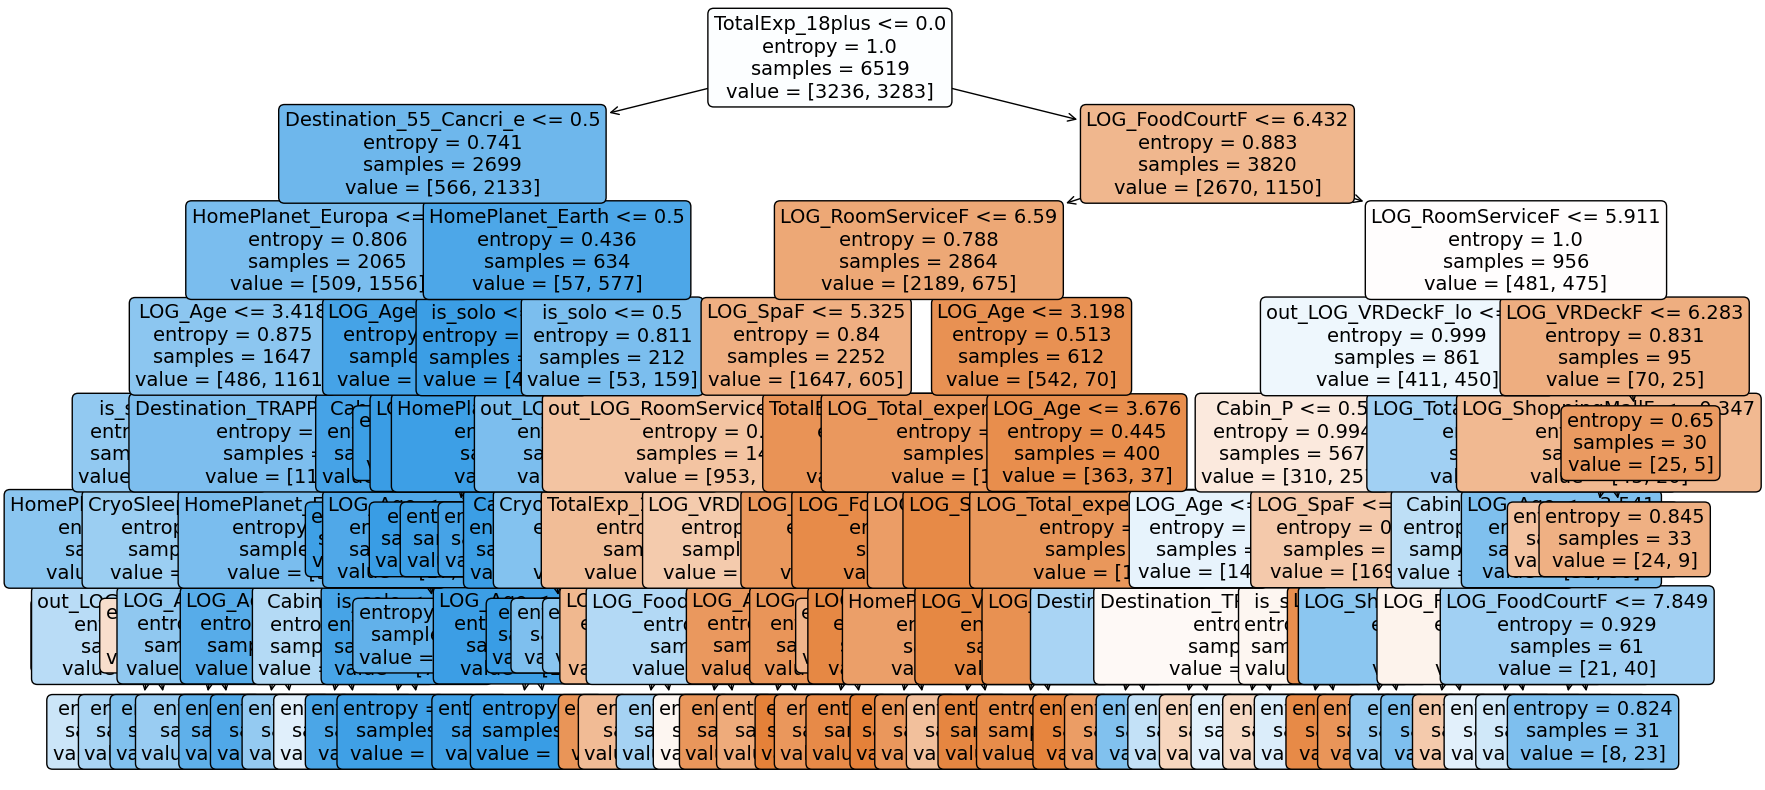

In [44]:
# setting figure size
plt.figure(figsize=(20, 10)) # adjusting to better fit the visual


# developing a plotted tree
sklearn.tree.plot_tree(decision_tree = dtc, # changing to pruned_tree_fit
          feature_names = x_train.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)  # Font size set at 14


# rendering the plot
plt.show()


# Fetaures' Importance 

As seen below in the importance graph, the features with the highest importance in our analysis are mainly amenities expenditures, and planets of origin, but there is one that stands out of the rest by a lot, which is “TotalExp_18plus”. 

This last one has the highest importance of all, which means that it’s the greatest contributor in making our best model’s accuracy score high. This has been possible, because, this feature has been engineered on top of two other strong features (with low p-values). The other features were total expenditure coming from adding all amenities, such as Spa, and Shopping Mall… as well as getting a strong age group (18+). 

It can be inferred that the more these 18+-year-old passengers spend the more likely are to be transported. But also, if the other, not so strong, but also important variables are taken into account, it can be said that these 18+ year-olds coming from mainly Earth, but also from Europa, also make this prediction strong, and therefore they should be considered in order to find the transported passengers. 


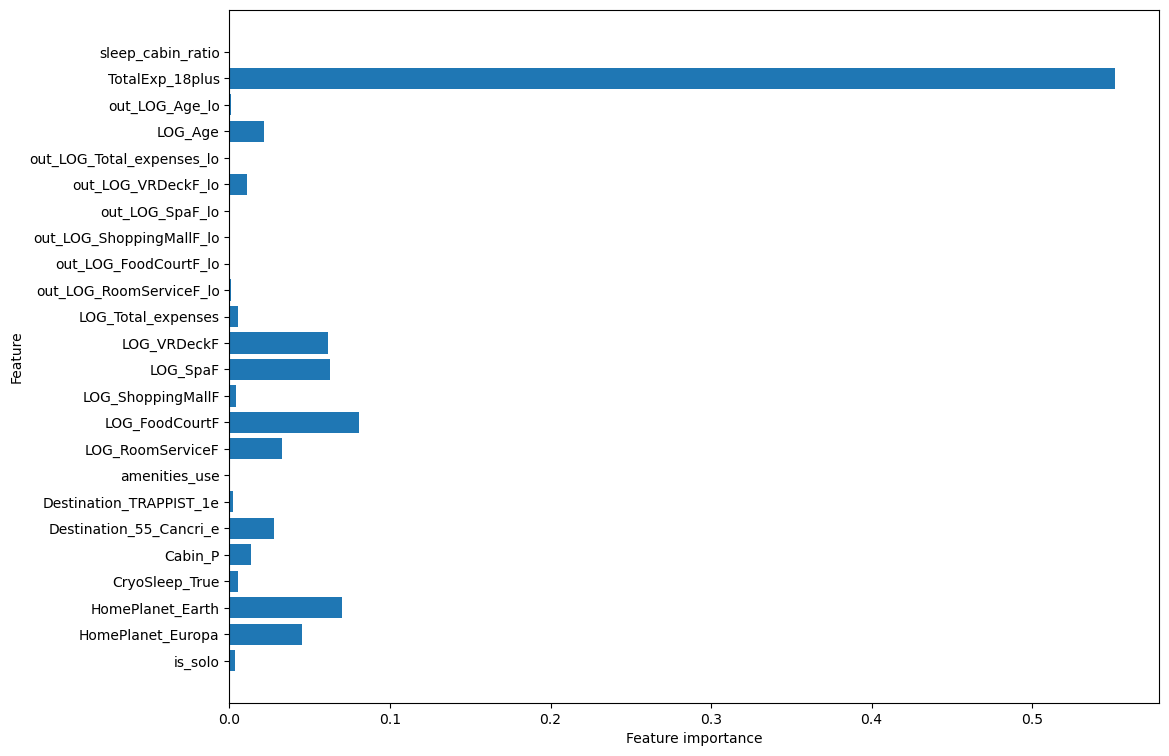

In [45]:
# plotting feature importance
plot_feature_importances(dtc,
                         train = x_train,
                         export = False)


In [46]:
########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,    # Anotations added
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues', # color set to blues
                fmt         = 'g')

    # # set the axis labels and title of the plot
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

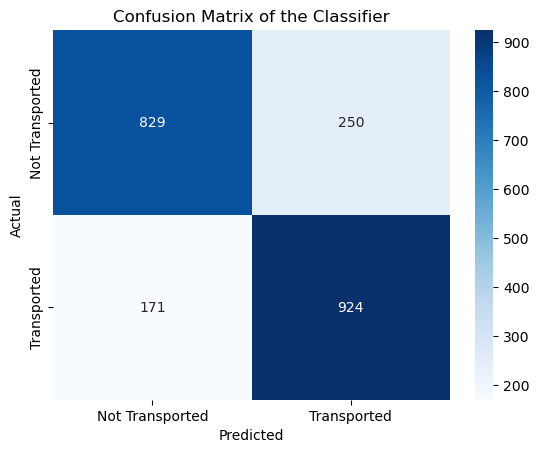

In [47]:
# calling the visual_cm function
visual_cm(true_y = y_train_2,
          pred_y = model_valid_pred,
          labels = ['Not Transported', 'Transported'])

The confusion matrix in Python can be read as follows:

~~~
                   |
  True Negatives   |  False Positives
  (correct)        |  (incorrect)
                   |
-------------------|------------------
                   |
  False Negatives  |  True Positives
  (incorrect)      |  (correct)
                   |
~~~


In terms of our model:



~~~

                                          |
PREDICTED: Transported (Yes)              |  PREDICTED: Not Transported (No)
ACTUAL:    Transported (Yes)              |  ACTUAL:    Not Transported (No)
                                          |
------------------------------------------|-------------------------------------
                                          |
PREDICTED:  Transported (Yes)             |  PREDICTED: Not Transported (No)
ACTUAL:    Not Transported (No)           |  ACTUAL:    Transported (Yes)
                                          |  

~~~

Based on the confusion matrix, the model correctly predicted that 928 passengers would be transported (true positives) and correctly predicted that 826 passengers would not be transported (true negatives).


However, the model incorrectly predicted that 253 passengers would be transported when they actually did not (false positives) and incorrectly predicted that 167 passengers would not be transported when they did (false negatives).

Text(0.5, 1.0, 'Prediction distribution')

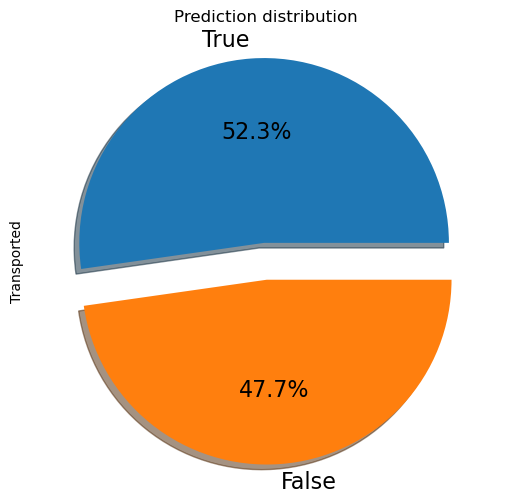

In [48]:
# Sample submission (to get right format)
sub=pd.read_csv('new_best_score.csv')

# # Add predictions
# sub['Transported']=preds_tuned

# # Replace 0 to False and 1 to True
# sub=sub.replace({0:False, 1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True,
                                           textprops={'fontsize':16}).set_title("Prediction distribution")

Our Analysis was done to understand the likelihood of passengers being transported.

After Analysis, we could predict with a reasonable degree of accuracy (80%) whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision.

Out of the passengers whose records were recovered from the Spaceship's damaged computer system, 52.4% were transported and 47.6% were safe. This means that almost half of the passengers were lucky enough to have avoided the anomaly's effects.

These passengers can be identified by their PassengerIds during the expedition as part of a set of personal records recovered. 


It is good to highlight here that the use of data analysis helped us gain insights and make predictions that can be helpful in making informed decisions (to rescue as many people as possible) .
In this case, moreover, the analysis can assist in understanding the impact of the anomaly and potentially help in developing strategies to prevent or mitigate similar incidents in the future.



In [49]:
x_train_iloc = x_train.iloc[:5, :]
y_train_iloc = y_train.iloc[:5]
x_train_iloc

,is_solo,HomePlanet_Europa,HomePlanet_Earth,CryoSleep_True,Cabin_P,Destination_55_Cancri_e,Destination_TRAPPIST_1e,amenities_use,LOG_RoomServiceF,LOG_FoodCourtF,LOG_ShoppingMallF,LOG_SpaF,LOG_VRDeckF,LOG_Total_expenses,out_LOG_RoomServiceF_lo,out_LOG_FoodCourtF_lo,out_LOG_ShoppingMallF_lo,out_LOG_SpaF_lo,out_LOG_VRDeckF_lo,out_LOG_Total_expenses_lo,LOG_Age,out_LOG_Age_lo,TotalExp_18plus,sleep_cabin_ratio
0,1,1,0,0,1,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,3.663562,0,0.000000,0.722064
1,1,0,1,0,0,0,1,1,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588,0,0,0,0,0,0,3.178054,0,0.107791,0.722064
2,0,1,0,0,0,0,1,1,3.784190,8.182280,0.000000,8.812248,3.912023,9.248021,0,0,1,0,0,0,4.060443,0,1.520650,0.722064
3,0,1,0,0,0,0,1,1,0.000000,7.157735,5.918894,8.110728,5.267858,8.551981,1,0,0,0,0,0,3.496508,0,0.758055,0.722064
4,1,0,1,0,0,0,1,1,5.717028,4.262680,5.023881,6.338594,1.098612,6.995766,0,0,0,0,1,0,2.772589,0,0.159783,0.722064


In [50]:
# unpacking the confusion matrix
dtc_tn, \
dtc_fp, \
dtc_fn, \
dtc_tp = confusion_matrix(y_true = y_train_2, y_pred = model_valid_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {dtc_tn}  
False Positives: {dtc_fp}
False Negatives: {dtc_fn}
True Positives : {dtc_tp}
""")


True Negatives : 829  
False Positives: 250
False Negatives: 171
True Positives : 924



--------------------------------------
*  Our Best Model’s Confusion Matrix 
--------------------------------------

From the results, false negatives are more serious than false positives in this problem.

False negatives mean that the passengers who were actually affected by the anomaly were not identified by our model, and hence rescue teams would not be able to help them. False positives mean that some passengers who were not actually affected by the anomaly would be temporarily inconvenienced by rescue efforts but would eventually be found safe. This is why the focus should be on minimizing false negatives in order to save as many passengers as possible, the drawback/risk of errors for the rescue team would be that they would lose almost 10% of the passengers, which would be a huge loss of life and resources.

In terms of error minimization, the teams should be more interested in minimizing false negatives because a passenger was actually transported but our model failed to predict it. 

Using the numbers from the given confusion matrix, we can calculate the following ratios:
False Positive Rate (FPR),False Negative Rate (FNR),Positive Predictive Value (PPV),Negative Predictive Value (NPV)

FPR = 253 / (253 + 826) = 0.235

FNR = 167 / (167 + 928) = 0.152

PPV = Precision = 928 / (928 + 253) = 0.785

NPV = 826 / (826 + 167) = 0.821

Sensitivity = Recall = TPR = 928 / (928 + 167) = 0.837
Specificity = TNR = 826 / (826 + 253) = 0.763

These ratios can provide a deeper understanding of the performance of the model and help in making decisions on how to improve it. (Basic Evaluation Measures From the Confusion Matrix, 2017)



# CONCLUSION

In conclusion, our analysis of the Spaceship Titanic dataset on Kaggle provided us with several actionable insights. Our feature engineering revealed that the group that spent the most on the ship's amenities were the 45+ year-olds, followed by the under-aged passengers (18- year-olds). This contradicts what the US Bureau of labor Statistics claimed, which stated that the 35 - 64 year-olds are the group that spends the most, except for alcohol, healthcare, and cash payments. 

Additionally, we found that false negatives are more serious than false positives when it comes to identifying transported passengers in a disaster scenario. The StackingClassifier model we used to predict transported passengers achieved a test accuracy of 0.8068 and we observed that it was doing a good job at predicting the outcomes of the data that it had been trained on and the new data that it hadn't seen before. Our findings can assist in the development of better safety measures on spaceships and in emergency response protocols in the case of disasters.

# Sources

U.S. Bureau of Labor Statistics. (2017). Spending patterns by age. Beyond the Numbers, 6(19). https://www.bls.gov/opub/btn/archive/spending-patterns-by-age.pdf 

Basic evaluation measures from the confusion matrix. (2017, September 13). Classifier Evaluation With Imbalanced Datasets. https://classeval.wordpress.com/introduction/basic-evaluation-measures/ 

Ciaburro, G. (2018). Regression analysis with R : design and develop statistical nodes to identify unique relationships within data at scale. Packt Publishing. Retrieved March 7, 2023.

Neuman, M., Jonsson, V., Calatayud, J., & Rosvall, M. (2022). Cross-validation of correlation networks using modular structure. Applied Network Science, 7(1). https://doi.org/10.1007/s41109-022-00516-5

Chen, H., Liu, Z.-G., Geng, M.-Y., Meng, X.-Y., Fu, W.-L., Ju, L., Yu, B.-Y., Yang, W., Dai, Y.-Q., Lu, W.-B., & Bartolomeo, A. D. (2022). A study on the dynamic tunning range of cvd graphene at microwave frequency: determination, prediction and application. Nanomaterials, 12(24). https://doi.org/10.3390/nano12244424

Penn State Eberly College of Science. (n.d.). Measures of Center. Online Statistics Education: An Interactive Multimedia Course of Study. Retrieved March 11, 2023, from https://online.stat.psu.edu/stat200/lesson/2/2.2/2.2.4/2.2.4.1  